A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.


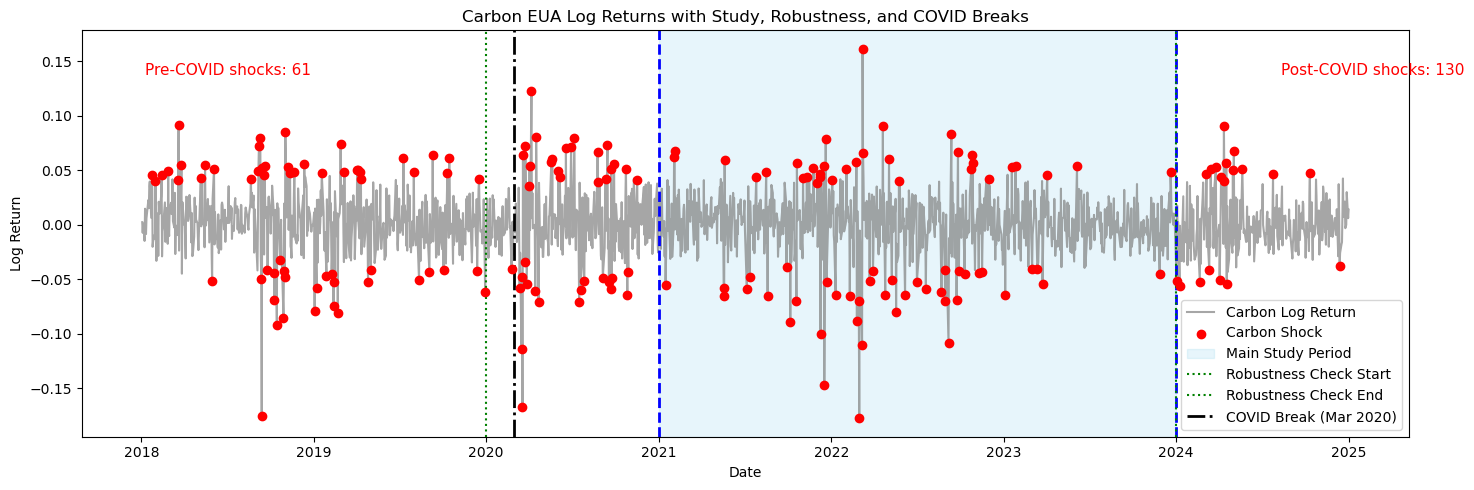

Notes: Dashed blue lines mark the start and end of the main study period (2021–2023), with the shaded region highlighting this window. Dotted green lines indicate the broader period used for robustness checks. The dash-dot black line marks the onset of COVID-19 disruptions (March 2020). Red points indicate identified carbon shock days, with 61 shocks before COVID and 130 after. This separation highlights regime differences in carbon market volatility.


In [62]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# 1. Load data
df = pd.read_csv('/Users/marcomontenegro/Desktop/MSQE PROJECT/Project_Data/financial_data_returns_2018_2024.csv', index_col=0, parse_dates=True)

# 2. Find carbon return column
def find_col(substring, columns):
    for col in columns:
        if substring.lower() in col.lower():
            return col
    return None

carbon_col = find_col('carbon_eua', df.columns)
carbon_ret_col = find_col('carbon_eua_ret', df.columns)

if not carbon_ret_col:
    if carbon_col:
        df['carbon_eua_ret'] = np.log(df[carbon_col] / df[carbon_col].shift(1))
        carbon_ret_col = 'carbon_eua_ret'
    else:
        raise Exception("Could not find a carbon price or return column.")

# 3. Fit AR(5) model and get residuals
carbon_ret = df[carbon_ret_col].dropna()
model = ARIMA(carbon_ret, order=(5, 0, 0))
fit = model.fit()
resid = fit.resid
df.loc[resid.index, 'carbon_shock_resid'] = resid

# 4. Flag shocks
shock_threshold = 1.5 * np.std(resid)
df['carbon_shock'] = (df['carbon_shock_resid'].abs() > shock_threshold).astype(int)

# --- Quantify pre- and post-COVID shocks ---
covid_break = pd.Timestamp('2020-03-01')
n_shocks_pre = df[(df.index < covid_break) & (df['carbon_shock'] == 1)].shape[0]
n_shocks_post = df[(df.index >= covid_break) & (df['carbon_shock'] == 1)].shape[0]

# --- Refined Visualization ---
start_main, end_main = pd.Timestamp('2021-01-01'), pd.Timestamp('2023-12-31')
start_robust, end_robust = pd.Timestamp('2020-01-01'), pd.Timestamp('2024-01-01')

plt.figure(figsize=(15,5))
plt.plot(df.index, df[carbon_ret_col], label='Carbon Log Return', color='gray', alpha=0.7)
plt.scatter(df[df['carbon_shock'] == 1].index, df.loc[df['carbon_shock'] == 1, carbon_ret_col],
            color='red', label='Carbon Shock', zorder=10)

# Main study period shading
plt.axvspan(start_main, end_main, color='skyblue', alpha=0.2, label='Main Study Period')

# Vertical lines for period bounds
plt.axvline(start_main, color='blue', linestyle='--', linewidth=2)
plt.axvline(end_main, color='blue', linestyle='--', linewidth=2)

# Optionally mark robustness window
plt.axvline(start_robust, color='green', linestyle=':', linewidth=1.5, label='Robustness Check Start')
plt.axvline(end_robust, color='green', linestyle=':', linewidth=1.5, label='Robustness Check End')

# COVID break line
plt.axvline(covid_break, color='black', linestyle='-.', linewidth=2, label='COVID Break (Mar 2020)')

# Annotate counts
plt.text(df.index[5], df[carbon_ret_col].max()*0.85, 
         f'Pre-COVID shocks: {n_shocks_pre}', fontsize=11, color='red')
plt.text(df.index[-100], df[carbon_ret_col].max()*0.85, 
         f'Post-COVID shocks: {n_shocks_post}', fontsize=11, color='red')

plt.title('Carbon EUA Log Returns with Study, Robustness, and COVID Breaks')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.tight_layout()
plt.savefig('/Users/marcomontenegro/Desktop/MSQE PROJECT/Project_Data/carbon_returns_shocks_studyperiod.png', dpi=300)
plt.show()

# Figure Note Example (for your slide/report)
fig_note = (
    f"Notes: Dashed blue lines mark the start and end of the main study period (2021–2023), "
    f"with the shaded region highlighting this window. Dotted green lines indicate the broader period "
    f"used for robustness checks. The dash-dot black line marks the onset of COVID-19 disruptions (March 2020). "
    f"Red points indicate identified carbon shock days, with {n_shocks_pre} shocks before COVID and "
    f"{n_shocks_post} after. This separation highlights regime differences in carbon market volatility."
)
print(fig_note)


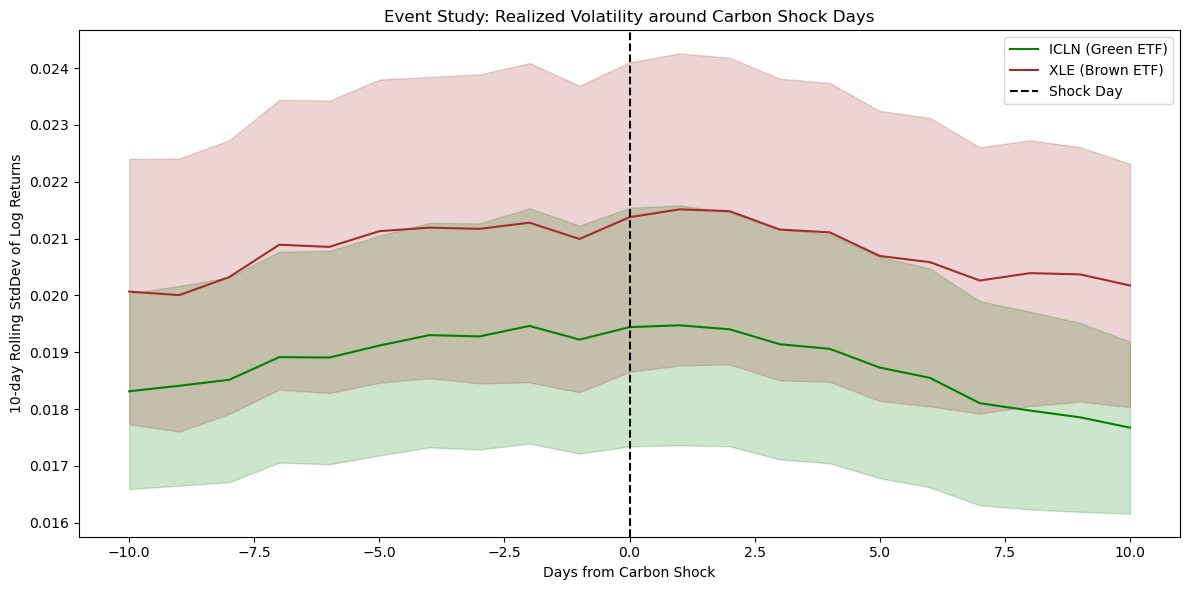

In [64]:
#Figure 5
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load data
df = pd.read_csv('/Users/marcomontenegro/Desktop/MSQE PROJECT/Project_Data/financial_data_returns_shocks_2018_2024.csv', index_col=0, parse_dates=True)

# Column detection
def find_col(substring, columns):
    for col in columns:
        if substring.lower() in col.lower():
            return col
    return None

icln_col = find_col('ICLN', df.columns)
xle_col = find_col('XLE', df.columns)
icln_ret_col = f'{icln_col}_ret'
xle_ret_col = f'{xle_col}_ret'

# Rolling volatility
vol_window = 10
df['icln_vol'] = df[icln_ret_col].rolling(window=vol_window).std()
df['xle_vol'] = df[xle_ret_col].rolling(window=vol_window).std()

# Shock event windows
shock_indices = df.index[df['carbon_shock'] == 1]
shock_indices = [idx for idx in shock_indices if (df.index.get_loc(idx) > 10) and (df.index.get_loc(idx) < len(df)-10)]

window = 10
event_matrix_icln_vol = []
event_matrix_xle_vol = []

for event_date in shock_indices:
    loc = df.index.get_loc(event_date)
    window_slice = slice(loc-window, loc+window+1)
    event_matrix_icln_vol.append(df.iloc[window_slice]['icln_vol'].values)
    event_matrix_xle_vol.append(df.iloc[window_slice]['xle_vol'].values)

event_matrix_icln_vol = np.array(event_matrix_icln_vol)
event_matrix_xle_vol = np.array(event_matrix_xle_vol)
event_time = np.arange(-window, window+1)

# Averages
mean_icln_vol = np.nanmean(event_matrix_icln_vol, axis=0)
mean_xle_vol = np.nanmean(event_matrix_xle_vol, axis=0)

# Standard error for CI
n_events = event_matrix_icln_vol.shape[0]
se_icln = np.nanstd(event_matrix_icln_vol, axis=0) / np.sqrt(n_events)
se_xle  = np.nanstd(event_matrix_xle_vol, axis=0) / np.sqrt(n_events)

# 95% CI
ci_upper_icln = mean_icln_vol + 1.96 * se_icln
ci_lower_icln = mean_icln_vol - 1.96 * se_icln
ci_upper_xle  = mean_xle_vol + 1.96 * se_xle
ci_lower_xle  = mean_xle_vol - 1.96 * se_xle

# --- Final Visual ---
plt.figure(figsize=(12,6))

# ICLN: mean and CI
plt.plot(event_time, mean_icln_vol, label='ICLN (Green ETF)', color='green')
plt.fill_between(event_time, ci_lower_icln, ci_upper_icln, color='green', alpha=0.2)

# XLE: mean and CI
plt.plot(event_time, mean_xle_vol, label='XLE (Brown ETF)', color='brown')
plt.fill_between(event_time, ci_lower_xle, ci_upper_xle, color='brown', alpha=0.2)

plt.axvline(0, color='black', linestyle='--', label='Shock Day')
plt.title('Event Study: Realized Volatility around Carbon Shock Days')
plt.xlabel('Days from Carbon Shock')
plt.ylabel('10-day Rolling StdDev of Log Returns')
plt.legend()
plt.tight_layout()
plt.savefig('/Users/marcomontenegro/Desktop/MSQE PROJECT/Project_Data/figure5_event_study_volatility.png', dpi=300)
plt.show()

The solid lines show the average 10-day rolling realized volatility for ICLN (green) and XLE (brown) ETFs across all detected carbon price shock events. The shaded regions indicate 95% confidence intervals based on cross-event variation at each event window day. The vertical dashed line marks the shock day (t=0). This event study design allows for visualization of typical ETF volatility dynamics in the days before and after a carbon price shock.

The left panel shows the performance of GARCH(1,1) and rolling baseline volatility forecasts for the clean energy ETF (ICLN, green); the right panel shows the same for the fossil energy ETF (XLE, brown). Solid colored lines are GARCH forecasts, black lines are realized volatility, and dotted gray lines are rolling baselines. GARCH generally tracks major volatility trends, but may lag behind sharp movements, especially in ICLN. Rolling baseline is a naive forecast and serves as a benchmark.


Training LSTM model for ICLN volatility forecasting...
Epoch 1/100


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0141  
Epoch 2/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0032
Epoch 3/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0034
Epoch 4/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0026
Epoch 5/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0021
Epoch 6/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0016
Epoch 7/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0017
Epoch 8/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0014   
Epoch 9/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0014   
Epoch 10/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0016
Epoch 11/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0012   
Epoch 12/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0012
Epoch 13/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0013
Epoch 14/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0011  
Epoch 15/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0012
Epo

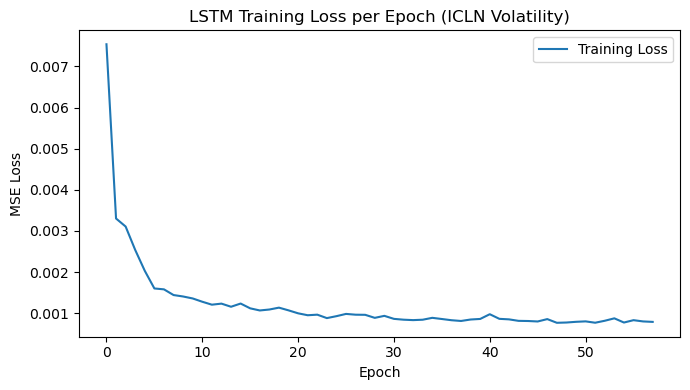

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

ICLN LSTM out-of-sample errors:
LSTM:  RMSE = 0.2176, MAE = 0.1290
GARCH: RMSE = 0.3262, MAE = 0.2544

Saved ICLN LSTM vs GARCH results as icln_volatility_forecast_lstm_vs_garch.csv


In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Load dataset
df = pd.read_csv('/Users/marcomontenegro/Desktop/MSQE PROJECT/Project_Data/financial_data_garch_2018_2024.csv', index_col=0, parse_dates=True)

# Robust column finding
def find_col(substring, columns):
    for col in columns:
        if substring.lower() in col.lower():
            return col
    return None

icln_ret_col = find_col('ICLN_ret', df.columns)
garch_vol_col = find_col('icln_garch_vol', df.columns)

# Prepare volatility target (realized 10-day rolling std, scaled to %)
window = 10
df['icln_realized_vol'] = df[icln_ret_col].rolling(window=window).std() * 100

# Drop NA for modeling
df_ml = df[['icln_realized_vol', garch_vol_col]].dropna().copy()

# Prepare lagged features for time series (past N lags to predict next volatility)
N_LAGS = 10
features = []
targets = []

for i in range(N_LAGS, len(df_ml)):
    features.append(df_ml['icln_realized_vol'].iloc[i-N_LAGS:i].values)
    targets.append(df_ml['icln_realized_vol'].iloc[i])

features = np.array(features)
targets = np.array(targets).reshape(-1,1)

# Scale features & targets
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
features_scaled = scaler_X.fit_transform(features)
targets_scaled = scaler_y.fit_transform(targets)

# Split into train/test
split_idx = int(len(features_scaled)*0.8)
X_train, X_test = features_scaled[:split_idx], features_scaled[split_idx:]
y_train, y_test = targets_scaled[:split_idx], targets_scaled[split_idx:]

# LSTM expects [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], N_LAGS, 1))
X_test  = X_test.reshape((X_test.shape[0], N_LAGS, 1))

# Build LSTM model
model = Sequential()
model.add(LSTM(32, input_shape=(N_LAGS, 1), return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Set up early stopping
early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# Train model for up to 100 epochs, with early stopping
print("Training LSTM model for ICLN volatility forecasting...")
history = model.fit(
    X_train, y_train, 
    epochs=100, 
    batch_size=16, 
    verbose=1,
    callbacks=[early_stop]
)

# Plot the training loss curve
plt.figure(figsize=(7,4))
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('LSTM Training Loss per Epoch (ICLN Volatility)')
plt.legend()
plt.tight_layout()
plt.show()

# Forecast
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_inv = scaler_y.inverse_transform(y_test)

# Match dates
test_dates = df_ml.index[N_LAGS+split_idx:]

# GARCH for same dates
garch_for_test = df_ml[garch_vol_col].iloc[N_LAGS+split_idx:].values

# Compute errors
rmse_lstm = np.sqrt(mean_squared_error(y_test_inv, y_pred))
mae_lstm  = mean_absolute_error(y_test_inv, y_pred)
rmse_garch = np.sqrt(mean_squared_error(y_test_inv, garch_for_test))
mae_garch  = mean_absolute_error(y_test_inv, garch_for_test)

print("\nICLN LSTM out-of-sample errors:")
print(f"LSTM:  RMSE = {rmse_lstm:.4f}, MAE = {mae_lstm:.4f}")
print(f"GARCH: RMSE = {rmse_garch:.4f}, MAE = {mae_garch:.4f}")

# Save outputs for report
results = pd.DataFrame({
    'date': test_dates,
    'realized_vol': y_test_inv.flatten(),
    'lstm_forecast': y_pred.flatten(),
    'garch_forecast': garch_for_test.flatten()
}).set_index('date')
results.to_csv('/Users/marcomontenegro/Desktop/MSQE PROJECT/Project_Data/icln_volatility_forecast_lstm_vs_garch.csv')
print("\nSaved ICLN LSTM vs GARCH results as icln_volatility_forecast_lstm_vs_garch.csv")

# ------------------------------------------------------------
# END OF CHUNK 11 (ICLN)
# ------------------------------------------------------------


Training LSTM model for XLE volatility forecasting...
Epoch 1/100


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0070 
Epoch 2/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0026
Epoch 3/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0023
Epoch 4/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0017   
Epoch 5/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0013
Epoch 6/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0015
Epoch 7/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0010   
Epoch 8/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0014    
Epoch 9/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.6211e-04
Epoch 10/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0010   
Epoch 11/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0011   
Epoch 12/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.0977e-04
Epoch 13/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0010   
Epoch 14/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.0849e-04
Epoch 15/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

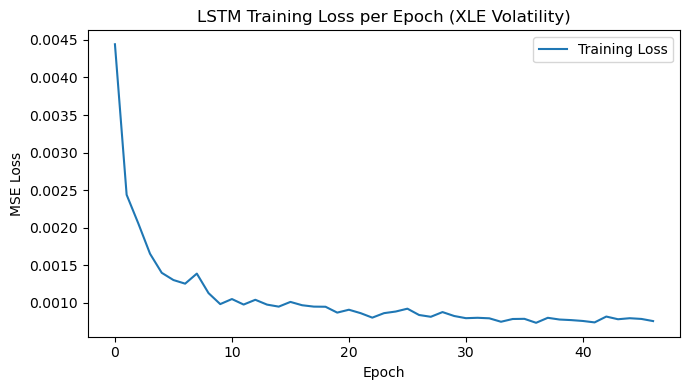

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

XLE LSTM out-of-sample errors:
LSTM:  RMSE = 0.1600, MAE = 0.1155
GARCH: RMSE = 0.2477, MAE = 0.2004

Saved XLE LSTM vs GARCH results as xle_volatility_forecast_lstm_vs_garch.csv


In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Load dataset
df = pd.read_csv('/Users/marcomontenegro/Desktop/MSQE PROJECT/Project_Data/financial_data_garch_2018_2024.csv', index_col=0, parse_dates=True)

# Robust column finding
def find_col(substring, columns):
    for col in columns:
        if substring.lower() in col.lower():
            return col
    return None

xle_ret_col = find_col('XLE_ret', df.columns)
garch_vol_col = find_col('xle_garch_vol', df.columns)

# Prepare volatility target (realized 10-day rolling std, scaled to %)
window = 10
df['xle_realized_vol'] = df[xle_ret_col].rolling(window=window).std() * 100

# Drop NA for modeling
df_ml = df[['xle_realized_vol', garch_vol_col]].dropna().copy()

# Prepare lagged features for time series (past N lags to predict next volatility)
N_LAGS = 10
features = []
targets = []

for i in range(N_LAGS, len(df_ml)):
    features.append(df_ml['xle_realized_vol'].iloc[i-N_LAGS:i].values)
    targets.append(df_ml['xle_realized_vol'].iloc[i])

features = np.array(features)
targets = np.array(targets).reshape(-1,1)

# Scale features & targets
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
features_scaled = scaler_X.fit_transform(features)
targets_scaled = scaler_y.fit_transform(targets)

# Split into train/test
split_idx = int(len(features_scaled)*0.8)
X_train, X_test = features_scaled[:split_idx], features_scaled[split_idx:]
y_train, y_test = targets_scaled[:split_idx], targets_scaled[split_idx:]

# LSTM expects [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], N_LAGS, 1))
X_test  = X_test.reshape((X_test.shape[0], N_LAGS, 1))

# Build LSTM model
model = Sequential()
model.add(LSTM(32, input_shape=(N_LAGS, 1), return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Set up early stopping
early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# Train model for up to 100 epochs, with early stopping
print("Training LSTM model for XLE volatility forecasting...")
history = model.fit(
    X_train, y_train, 
    epochs=100, 
    batch_size=16, 
    verbose=1,
    callbacks=[early_stop]
)

# Plot the training loss curve
plt.figure(figsize=(7,4))
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('LSTM Training Loss per Epoch (XLE Volatility)')
plt.legend()
plt.tight_layout()
plt.show()

# Forecast
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_inv = scaler_y.inverse_transform(y_test)

# Match dates
test_dates = df_ml.index[N_LAGS+split_idx:]

# GARCH for same dates
garch_for_test = df_ml[garch_vol_col].iloc[N_LAGS+split_idx:].values

# Compute errors
rmse_lstm = np.sqrt(mean_squared_error(y_test_inv, y_pred))
mae_lstm  = mean_absolute_error(y_test_inv, y_pred)
rmse_garch = np.sqrt(mean_squared_error(y_test_inv, garch_for_test))
mae_garch  = mean_absolute_error(y_test_inv, garch_for_test)

print("\nXLE LSTM out-of-sample errors:")
print(f"LSTM:  RMSE = {rmse_lstm:.4f}, MAE = {mae_lstm:.4f}")
print(f"GARCH: RMSE = {rmse_garch:.4f}, MAE = {mae_garch:.4f}")

# Save outputs for report
results = pd.DataFrame({
    'date': test_dates,
    'realized_vol': y_test_inv.flatten(),
    'lstm_forecast': y_pred.flatten(),
    'garch_forecast': garch_for_test.flatten()
}).set_index('date')
results.to_csv('/Users/marcomontenegro/Desktop/MSQE PROJECT/Project_Data/xle_volatility_forecast_lstm_vs_garch.csv')
print("\nSaved XLE LSTM vs GARCH results as xle_volatility_forecast_lstm_vs_garch.csv")

# ------------------------------------------------------------
# END OF CHUNK 11B (XLE)
# ------------------------------------------------------------


'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



Model Out-of-Sample Error Metrics (Volatility):
    ETF  Model      RMSE       MAE
0  ICLN   LSTM  0.217619  0.129023
1  ICLN  GARCH  0.326244  0.254432
2   XLE   LSTM  0.159997  0.115538
3   XLE  GARCH  0.247715  0.200415

Saved performance summary as volatility_model_performance_summary.csv


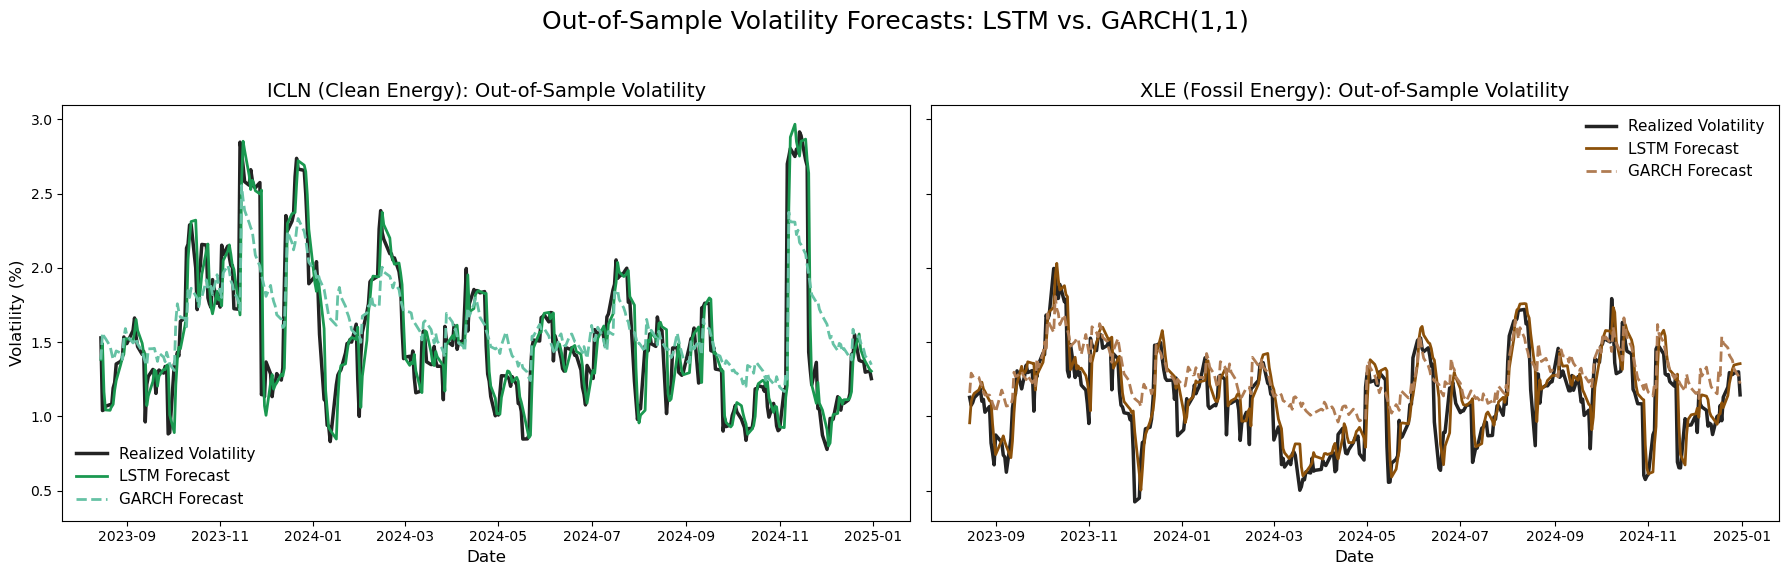

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load results
icln_res = pd.read_csv('/Users/marcomontenegro/Desktop/MSQE PROJECT/Project_Data/icln_volatility_forecast_lstm_vs_garch.csv', parse_dates=['date'], index_col='date')
xle_res  = pd.read_csv('/Users/marcomontenegro/Desktop/MSQE PROJECT/Project_Data/xle_volatility_forecast_lstm_vs_garch.csv', parse_dates=['date'], index_col='date')

# Compute metrics for ICLN
rmse_lstm_icln = mean_squared_error(icln_res['realized_vol'], icln_res['lstm_forecast'], squared=False)
mae_lstm_icln  = mean_absolute_error(icln_res['realized_vol'], icln_res['lstm_forecast'])
rmse_garch_icln = mean_squared_error(icln_res['realized_vol'], icln_res['garch_forecast'], squared=False)
mae_garch_icln  = mean_absolute_error(icln_res['realized_vol'], icln_res['garch_forecast'])

# Compute metrics for XLE
rmse_lstm_xle = mean_squared_error(xle_res['realized_vol'], xle_res['lstm_forecast'], squared=False)
mae_lstm_xle  = mean_absolute_error(xle_res['realized_vol'], xle_res['lstm_forecast'])
rmse_garch_xle = mean_squared_error(xle_res['realized_vol'], xle_res['garch_forecast'], squared=False)
mae_garch_xle  = mean_absolute_error(xle_res['realized_vol'], xle_res['garch_forecast'])

# Summary table (optional)
summary = pd.DataFrame({
    'ETF': ['ICLN', 'ICLN', 'XLE', 'XLE'],
    'Model': ['LSTM', 'GARCH', 'LSTM', 'GARCH'],
    'RMSE': [rmse_lstm_icln, rmse_garch_icln, rmse_lstm_xle, rmse_garch_xle],
    'MAE': [mae_lstm_icln, mae_garch_icln, mae_lstm_xle, mae_garch_xle]
})
print("\nModel Out-of-Sample Error Metrics (Volatility):")
print(summary)
summary.to_csv('/Users/marcomontenegro/Desktop/MSQE PROJECT/Project_Data/volatility_model_performance_summary.csv', index=False)
print("\nSaved performance summary as volatility_model_performance_summary.csv")

# --- Refined Side-by-Side Panel Plot ---
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# Colors
realized_color = '#232323'    # Very dark gray (almost black)
lstm_icln_color = '#1a9850'   # Green
garch_icln_color = '#66c2a5'  # Light green (ICLN GARCH)
lstm_xle_color = '#8c510a'    # Brown
garch_xle_color = '#b07c53'   # Light brown (XLE GARCH)


# ICLN subplot
axes[0].plot(icln_res.index, icln_res['realized_vol'], label='Realized Volatility', color=realized_color, linewidth=2.5)
axes[0].plot(icln_res.index, icln_res['lstm_forecast'], label='LSTM Forecast', color=lstm_icln_color, linewidth=2)
axes[0].plot(icln_res.index, icln_res['garch_forecast'], label='GARCH Forecast', color=garch_icln_color, linewidth=2, linestyle='--')
axes[0].set_title('ICLN (Clean Energy): Out-of-Sample Volatility', fontsize=14)
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('Volatility (%)', fontsize=12)
axes[0].legend(fontsize=11, frameon=False)

# XLE subplot
axes[1].plot(xle_res.index, xle_res['realized_vol'], label='Realized Volatility', color=realized_color, linewidth=2.5)
axes[1].plot(xle_res.index, xle_res['lstm_forecast'], label='LSTM Forecast', color=lstm_xle_color, linewidth=2)
axes[1].plot(xle_res.index, xle_res['garch_forecast'], label='GARCH Forecast', color=garch_xle_color, linewidth=2, linestyle='--')
axes[1].set_title('XLE (Fossil Energy): Out-of-Sample Volatility', fontsize=14)
axes[1].set_xlabel('Date', fontsize=12)
axes[1].legend(fontsize=11, frameon=False)

fig.suptitle('Out-of-Sample Volatility Forecasts: LSTM vs. GARCH(1,1)', fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('/Users/marcomontenegro/Desktop/MSQE PROJECT/Project_Data/volatility_forecasts_lstm_vs_garch.png', dpi=300)
plt.show()


The left panel shows the performance of GARCH(1,1) and rolling baseline volatility forecasts for the clean energy ETF (ICLN, green); the right panel shows the same for the fossil energy ETF (XLE, brown). Solid colored lines are GARCH forecasts, black lines are realized volatility, and dotted gray lines are rolling baselines. GARCH generally tracks major volatility trends, but may lag behind sharp movements, especially in ICLN. Rolling baseline is a naive forecast and serves as a benchmark.


ICLN mean CATE: 0.05970
ICLN: t-stat = 19.15, p = 0.0000
ICLN bootstrapped 95% CI: 0.05377 to 0.06563
ICLN Placebo mean CATE: -0.00220, std = 0.04764


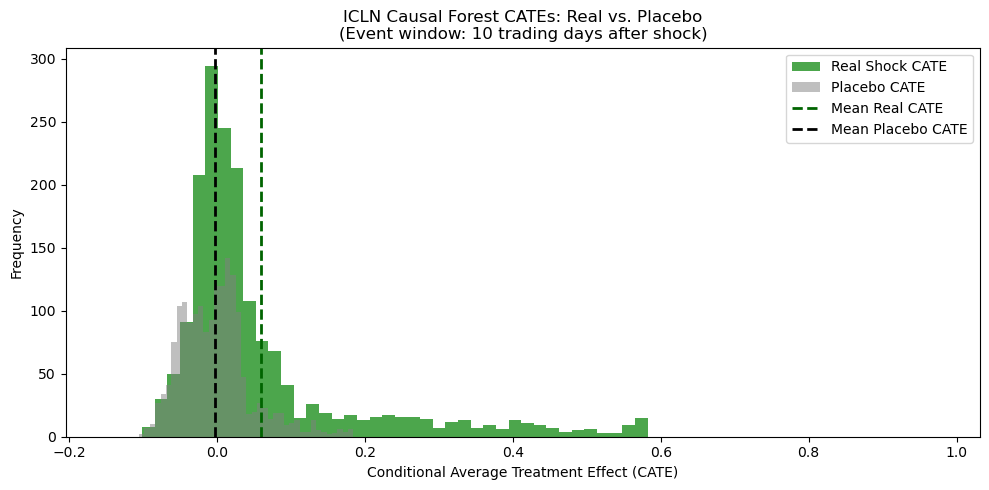


XLE mean CATE: 0.13301
XLE: t-stat = 29.40, p = 0.0000
XLE bootstrapped 95% CI: 0.12410 to 0.14191
XLE Placebo mean CATE: 0.01920, std = 0.04632


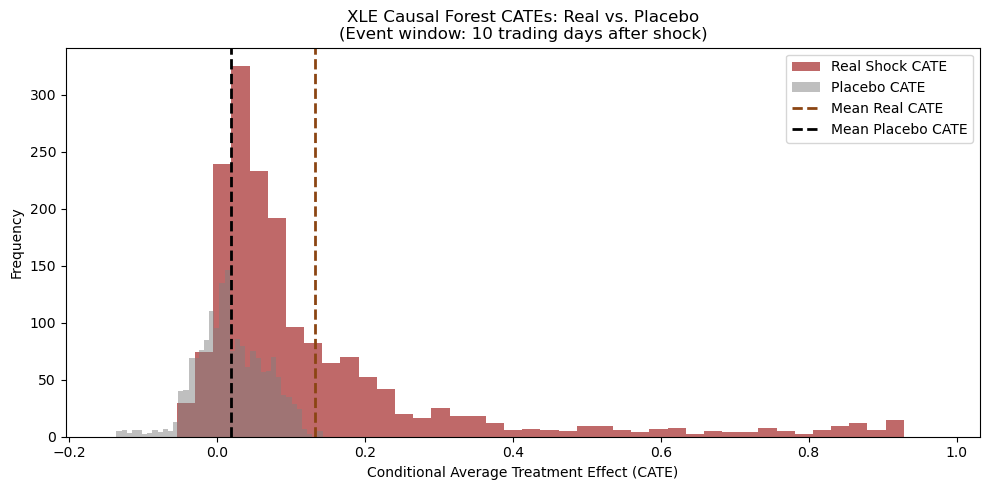


Saved robustness results as causal_forest_robustness_results.csv.


In [68]:
#Fig 10
import pandas as pd
import numpy as np
from scipy.stats import ttest_1samp
from econml.dml import CausalForestDML
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import re

# Load data and CATEs
df = pd.read_csv('/Users/marcomontenegro/Desktop/MSQE PROJECT/Project_Data/financial_data_returns_shocks_vol_2018_2024.csv', index_col=0, parse_dates=True)
def clean_col(col):
    s = re.sub(r'[^0-9a-zA-Z_]+', '_', col).strip('_')
    s = re.sub(r'_+', '_', s)
    return s.lower()
df.columns = [clean_col(col) for col in df.columns]

def find_col(substring, columns):
    substring = substring.lower().strip('_')
    for col in columns:
        if substring in col.strip('_').lower():
            return col
    return None

def valid_controls(cols, df):
    controls = []
    for col in cols:
        if col and col in df.columns:
            ser = df[col]
            if pd.api.types.is_numeric_dtype(ser) and ser.notnull().sum() > 1 and ser.nunique(dropna=True) > 1:
                controls.append(col)
    return controls

vix_col = find_col('vix', df.columns)
brent_col = find_col('brent', df.columns)
sp500_ret_col = find_col('sp500_ret', df.columns)
dgs10_col = find_col('dgs10', df.columns)
macro_controls = valid_controls([vix_col, brent_col, sp500_ret_col, dgs10_col], df)

icln_ret_col = find_col('icln_ret', df.columns)
icln_vol_col = find_col('icln_vol', df.columns)
xle_ret_col = find_col('xle_ret', df.columns)
xle_vol_col = find_col('xle_vol', df.columns)
carbon_shock_col = find_col('carbon_shock', df.columns)

def bootstrap_ci(series, n_boot=1000, ci=95):
    means = []
    for _ in range(n_boot):
        means.append(series.sample(frac=1, replace=True).mean())
    lower = np.percentile(means, (100-ci)/2)
    upper = np.percentile(means, 100-(100-ci)/2)
    return lower, upper

results_df = []

# Get all real CATEs to set a consistent x-axis across ICLN and XLE
all_cates = []
for label in ['ICLN', 'XLE']:
    try:
        cate_path = f'/Users/marcomontenegro/Desktop/MSQE PROJECT/Project_Data/{label.lower()}_causal_forest_cates.csv'
        cate = pd.read_csv(cate_path, parse_dates=['date'], index_col='date')
        cate_col = cate.columns[0]
        all_cates.append(cate[cate_col].values)
    except Exception:
        pass
xmin = min(np.min(c) for c in all_cates)
xmax = max(np.max(c) for c in all_cates)
x_buffer = (xmax - xmin) * 0.1
xmin, xmax = xmin - x_buffer, xmax + x_buffer

# Main CATE analysis loop
for label, ret_col, vol_col in [
    ('ICLN', icln_ret_col, icln_vol_col),
    ('XLE', xle_ret_col, xle_vol_col)
]:
    try:
        cate_path = f'/Users/marcomontenegro/Desktop/MSQE PROJECT/Project_Data/{label.lower()}_causal_forest_cates.csv'
        cate = pd.read_csv(cate_path, parse_dates=['date'], index_col='date')
        cate_col = cate.columns[0]
        print(f"\n{label} mean CATE: {cate[cate_col].mean():.5f}")

        t_stat, p_val = ttest_1samp(cate[cate_col], 0)
        print(f"{label}: t-stat = {t_stat:.2f}, p = {p_val:.4f}")

        ci = bootstrap_ci(cate[cate_col])
        print(f"{label} bootstrapped 95% CI: {ci[0]:.5f} to {ci[1]:.5f}")

        # Placebo test (shuffle shocks)
        df_sub = df.dropna(subset=[ret_col, vol_col, carbon_shock_col] + macro_controls)
        Y = df_sub[ret_col].values
        T_real = df_sub[carbon_shock_col].values
        X = df_sub[[vol_col] + macro_controls].values
        np.random.seed(42)
        T_fake = np.random.permutation(T_real)
        est_fake = CausalForestDML(
            model_y=RandomForestRegressor(n_estimators=100, min_samples_leaf=10),
            model_t=RandomForestRegressor(n_estimators=100, min_samples_leaf=10),
            n_estimators=500,
            min_samples_leaf=10,
            verbose=0,
            random_state=42
        )
        est_fake.fit(Y, T_fake, X=X)
        fake_cate = est_fake.effect(X)
        print(f"{label} Placebo mean CATE: {np.mean(fake_cate):.5f}, std = {np.std(fake_cate):.5f}")

        # Histogram: Real vs. Placebo CATEs (with consistent x-axis and trading window noted)
        plt.figure(figsize=(10,5))
        plt.hist(cate[cate_col], bins=40, alpha=0.7, label='Real Shock CATE', color='green' if label == 'ICLN' else 'brown')
        plt.hist(fake_cate, bins=40, alpha=0.5, label='Placebo CATE', color='gray')
        plt.axvline(np.mean(cate[cate_col]), color='darkgreen' if label == 'ICLN' else 'saddlebrown', linestyle='--', linewidth=2, label='Mean Real CATE')
        plt.axvline(np.mean(fake_cate), color='black', linestyle='--', linewidth=2, label='Mean Placebo CATE')
        plt.title(f'{label} Causal Forest CATEs: Real vs. Placebo\n(Event window: 10 trading days after shock)')
        plt.xlabel('Conditional Average Treatment Effect (CATE)')
        plt.ylabel('Frequency')
        plt.xlim(xmin, xmax)
        plt.legend()
        plt.tight_layout()
        plt.savefig(f'/Users/marcomontenegro/Desktop/MSQE PROJECT/Project_Data/{label.lower()}_cate_histogram.png', dpi=300)
        plt.show()

        results_df.append({
            'ETF': label,
            'Mean_CATE': cate[cate_col].mean(),
            'T_stat': t_stat,
            'P_value': p_val,
            'Bootstrapped_CI_low': ci[0],
            'Bootstrapped_CI_high': ci[1],
            'Placebo_Mean_CATE': np.mean(fake_cate),
            'Placebo_Std_CATE': np.std(fake_cate)
        })
    except Exception as e:
        print(f"Could not compute robustness for {label}: {e}")

summary = pd.DataFrame(results_df)
summary.to_csv('/Users/marcomontenegro/Desktop/MSQE PROJECT/Project_Data/causal_forest_robustness_results.csv', index=False)
print("\nSaved robustness results as causal_forest_robustness_results.csv.")

# ------------------------------------------------------------
# END OF UPDATED CHUNK 14
# ------------------------------------------------------------


Histograms show the estimated distribution of Conditional Average Treatment Effects (CATEs) from a Causal Forest model, measured over a 10-day trading window following detected carbon price shocks. The x-axis is held constant across both ICLN (green, clean energy) and XLE (brown, fossil energy) to enable direct visual comparison of the ETFs' shock sensitivities. A pronounced right-skewed (long) tail in the CATE distribution for ICLN indicates substantial heterogeneity—while most trading windows show modest effects, a minority experience large, positive abnormal returns after shocks. This suggests certain subsectors or periods within ICLN can see outsized gains from carbon pricing events. In contrast, XLE's CATEs are more tightly distributed with fewer large outliers, highlighting weaker or more uniform responses to carbon shocks. The placebo distributions (gray) are tightly centered near zero, reinforcing the causal interpretation of the real shock estimates.

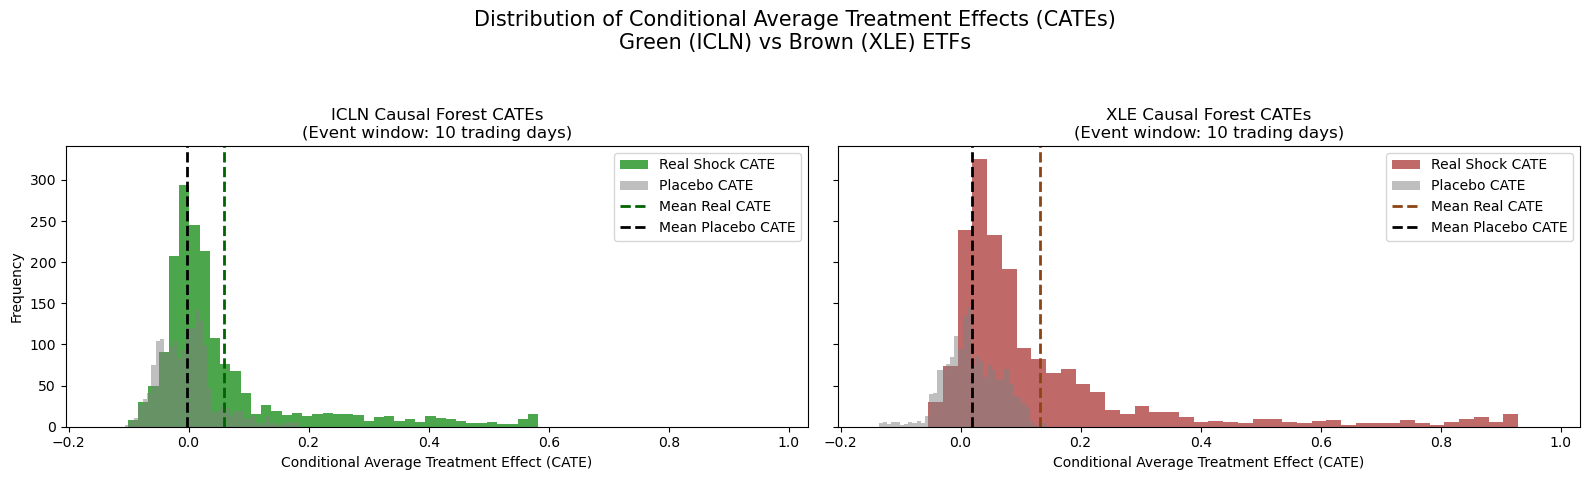

In [70]:
import numpy as np
from scipy.stats import ttest_1samp
from econml.dml import CausalForestDML
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import pandas as pd
import re

# Load and clean data
df = pd.read_csv('/Users/marcomontenegro/Desktop/MSQE PROJECT/Project_Data/financial_data_returns_shocks_vol_2018_2024.csv', index_col=0, parse_dates=True)
def clean_col(col):
    s = re.sub(r'[^0-9a-zA-Z_]+', '_', col).strip('_')
    s = re.sub(r'_+', '_', s)
    return s.lower()
df.columns = [clean_col(col) for col in df.columns]

def find_col(substring, columns):
    substring = substring.lower().strip('_')
    for col in columns:
        if substring in col.strip('_').lower():
            return col
    return None

def valid_controls(cols, df):
    controls = []
    for col in cols:
        if col and col in df.columns:
            ser = df[col]
            if pd.api.types.is_numeric_dtype(ser) and ser.notnull().sum() > 1 and ser.nunique(dropna=True) > 1:
                controls.append(col)
    return controls

vix_col = find_col('vix', df.columns)
brent_col = find_col('brent', df.columns)
sp500_ret_col = find_col('sp500_ret', df.columns)
dgs10_col = find_col('dgs10', df.columns)
macro_controls = valid_controls([vix_col, brent_col, sp500_ret_col, dgs10_col], df)

icln_ret_col = find_col('icln_ret', df.columns)
icln_vol_col = find_col('icln_vol', df.columns)
xle_ret_col = find_col('xle_ret', df.columns)
xle_vol_col = find_col('xle_vol', df.columns)
carbon_shock_col = find_col('carbon_shock', df.columns)

def bootstrap_ci(series, n_boot=1000, ci=95):
    means = []
    for _ in range(n_boot):
        means.append(series.sample(frac=1, replace=True).mean())
    lower = np.percentile(means, (100-ci)/2)
    upper = np.percentile(means, 100-(100-ci)/2)
    return lower, upper

results_df = []

# Store for combined plot
all_labels = []
all_real_cate = []
all_fake_cate = []

# Get all real CATEs to set a consistent x-axis
all_cates = []
for label in ['ICLN', 'XLE']:
    try:
        cate_path = f'/Users/marcomontenegro/Desktop/MSQE PROJECT/Project_Data/{label.lower()}_causal_forest_cates.csv'
        cate = pd.read_csv(cate_path, parse_dates=['date'], index_col='date')
        cate_col = cate.columns[0]
        all_cates.append(cate[cate_col].values)
    except Exception:
        pass
xmin = min(np.min(c) for c in all_cates)
xmax = max(np.max(c) for c in all_cates)
x_buffer = (xmax - xmin) * 0.1
xmin, xmax = xmin - x_buffer, xmax + x_buffer

# Main CATE analysis loop, store for plot
for label, ret_col, vol_col in [
    ('ICLN', icln_ret_col, icln_vol_col),
    ('XLE', xle_ret_col, xle_vol_col)
]:
    try:
        cate_path = f'/Users/marcomontenegro/Desktop/MSQE PROJECT/Project_Data/{label.lower()}_causal_forest_cates.csv'
        cate = pd.read_csv(cate_path, parse_dates=['date'], index_col='date')
        cate_col = cate.columns[0]
        # Placebo test (shuffle shocks)
        df_sub = df.dropna(subset=[ret_col, vol_col, carbon_shock_col] + macro_controls)
        Y = df_sub[ret_col].values
        T_real = df_sub[carbon_shock_col].values
        X = df_sub[[vol_col] + macro_controls].values
        np.random.seed(42)
        T_fake = np.random.permutation(T_real)
        est_fake = CausalForestDML(
            model_y=RandomForestRegressor(n_estimators=100, min_samples_leaf=10),
            model_t=RandomForestRegressor(n_estimators=100, min_samples_leaf=10),
            n_estimators=500,
            min_samples_leaf=10,
            verbose=0,
            random_state=42
        )
        est_fake.fit(Y, T_fake, X=X)
        fake_cate = est_fake.effect(X)

        # Store for combined plot
        all_labels.append(label)
        all_real_cate.append(cate[cate_col].values)
        all_fake_cate.append(fake_cate)
    except Exception as e:
        print(f"Could not compute robustness for {label}: {e}")

# --- Combined Panel Plot ---
fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

for i, label in enumerate(all_labels):
    real_color = 'green' if label == 'ICLN' else 'brown'
    mean_color = 'darkgreen' if label == 'ICLN' else 'saddlebrown'
    axes[i].hist(all_real_cate[i], bins=40, alpha=0.7, label='Real Shock CATE', color=real_color)
    axes[i].hist(all_fake_cate[i], bins=40, alpha=0.5, label='Placebo CATE', color='gray')
    axes[i].axvline(np.mean(all_real_cate[i]), color=mean_color, linestyle='--', linewidth=2, label='Mean Real CATE')
    axes[i].axvline(np.mean(all_fake_cate[i]), color='black', linestyle='--', linewidth=2, label='Mean Placebo CATE')
    axes[i].set_title(f'{label} Causal Forest CATEs\n(Event window: 10 trading days)')
    axes[i].set_xlabel('Conditional Average Treatment Effect (CATE)')
    axes[i].set_xlim(xmin, xmax)
    if i == 0:
        axes[i].set_ylabel('Frequency')
    axes[i].legend()

plt.suptitle('Distribution of Conditional Average Treatment Effects (CATEs)\nGreen (ICLN) vs Brown (XLE) ETFs', fontsize=15)
plt.tight_layout(rect=[0, 0.03, 1, 0.93])
plt.savefig('/Users/marcomontenegro/Desktop/MSQE PROJECT/Project_Data/combined_cate_histograms.png', dpi=300)
plt.show()


Cleaned columns: ['icln_icln', 'xle_xle', 'vix_vix', 'brent_bz_f', 'sp500_gspc', 'dgs10', 'carbon_eua', 'icln_icln_ret', 'xle_xle_ret', 'brent_bz_f_ret', 'carbon_eua_ret', 'sp500_gspc_ret', 'dgs10_diff', 'carbon_shock_resid', 'carbon_shock', 'icln_vol', 'xle_vol']

Detected columns:
icln_ret_col: icln_icln_ret
xle_ret_col: xle_xle_ret
carbon_shock_col: carbon_shock_resid
Fitting GARCH(1,1) for ICLN...
                       Zero Mean - GARCH Model Results                        
Dep. Variable:          icln_icln_ret   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -3335.95
Distribution:                  Normal   AIC:                           6677.90
Method:            Maximum Likelihood   BIC:                           6694.33
                                        No. Observations:                 1763
Date:                Sun, Jun 08 2025   Df

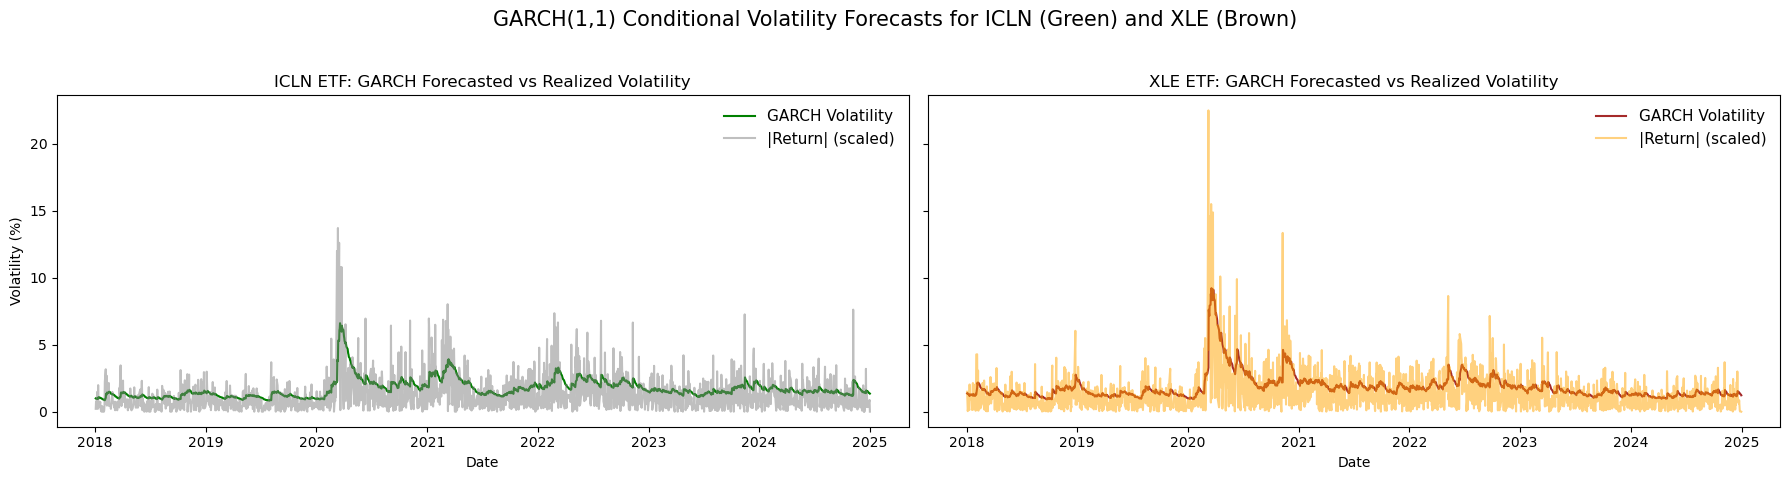


Saved GARCH results for both ICLN and XLE as financial_data_garch_2018_2024.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
import re

# Load your (already returns- and vol-augmented) dataset
df = pd.read_csv('/Users/marcomontenegro/Desktop/MSQE PROJECT/Project_Data/financial_data_returns_shocks_vol_2018_2024.csv', index_col=0, parse_dates=True)

def clean_col(col):
    s = re.sub(r'[^0-9a-zA-Z_]+', '_', col).strip('_')
    s = re.sub(r'_+', '_', s)
    return s.lower()

df.columns = [clean_col(col) for col in df.columns]
print("Cleaned columns:", list(df.columns))

def find_col(substring, columns):
    substring = substring.lower().strip('_')
    for col in columns:
        if substring in col.strip('_').lower():
            return col
    return None

icln_ret_col = find_col('icln_ret', df.columns)
xle_ret_col  = find_col('xle_ret', df.columns)
carbon_shock_col = find_col('carbon_shock', df.columns)

print("\nDetected columns:")
for name, val in [
    ('icln_ret_col', icln_ret_col), ('xle_ret_col', xle_ret_col), ('carbon_shock_col', carbon_shock_col)
]:
    print(f"{name}: {val}")

# Fit GARCH(1,1) models and store volatilities
if icln_ret_col:
    returns_icln = df[icln_ret_col].dropna() * 100  # scale for GARCH
    print("Fitting GARCH(1,1) for ICLN...")
    garch_icln = arch_model(returns_icln, vol='Garch', p=1, q=1, mean='Zero', rescale=False)
    garch_result_icln = garch_icln.fit(disp='off')
    print(garch_result_icln.summary())
    df.loc[returns_icln.index, 'icln_garch_vol'] = garch_result_icln.conditional_volatility
else:
    print("ICLN return column not found—skipping GARCH for ICLN.")

if xle_ret_col:
    returns_xle = df[xle_ret_col].dropna() * 100
    print("Fitting GARCH(1,1) for XLE...")
    garch_xle = arch_model(returns_xle, vol='Garch', p=1, q=1, mean='Zero', rescale=False)
    garch_result_xle = garch_xle.fit(disp='off')
    print(garch_result_xle.summary())
    df.loc[returns_xle.index, 'xle_garch_vol'] = garch_result_xle.conditional_volatility
else:
    print("XLE return column not found—skipping GARCH for XLE.")

# --- Side-by-side plot ---
fig, axes = plt.subplots(1, 2, figsize=(18, 5), sharey=True)

if icln_ret_col:
    axes[0].plot(df.loc[returns_icln.index].index, df.loc[returns_icln.index, 'icln_garch_vol'], label='GARCH Volatility', color='green')
    axes[0].plot(df.loc[returns_icln.index].index, np.abs(returns_icln), label='|Return| (scaled)', color='gray', alpha=0.5)
    axes[0].set_title('ICLN ETF: GARCH Forecasted vs Realized Volatility')
    axes[0].set_xlabel('Date')
    axes[0].set_ylabel('Volatility (%)')
    axes[0].legend(fontsize=11, frameon=False)

if xle_ret_col:
    axes[1].plot(df.loc[returns_xle.index].index, df.loc[returns_xle.index, 'xle_garch_vol'], label='GARCH Volatility', color='brown')
    axes[1].plot(df.loc[returns_xle.index].index, np.abs(returns_xle), label='|Return| (scaled)', color='orange', alpha=0.5)
    axes[1].set_title('XLE ETF: GARCH Forecasted vs Realized Volatility')
    axes[1].set_xlabel('Date')
    axes[1].legend(fontsize=11, frameon=False)

plt.suptitle('GARCH(1,1) Conditional Volatility Forecasts for ICLN (Green) and XLE (Brown)', fontsize=15)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('/Users/marcomontenegro/Desktop/MSQE PROJECT/Project_Data/garch_volatility_forecasts_panel.png', dpi=300)
plt.show()

# Save GARCH results for both ETFs
df.to_csv('/Users/marcomontenegro/Desktop/MSQE PROJECT/Project_Data/financial_data_garch_2018_2024.csv')
print("\nSaved GARCH results for both ICLN and XLE as financial_data_garch_2018_2024.csv")

# ------------------------------------------------------------
# END OF FULLY ROBUST CHUNK 9
# ------------------------------------------------------------


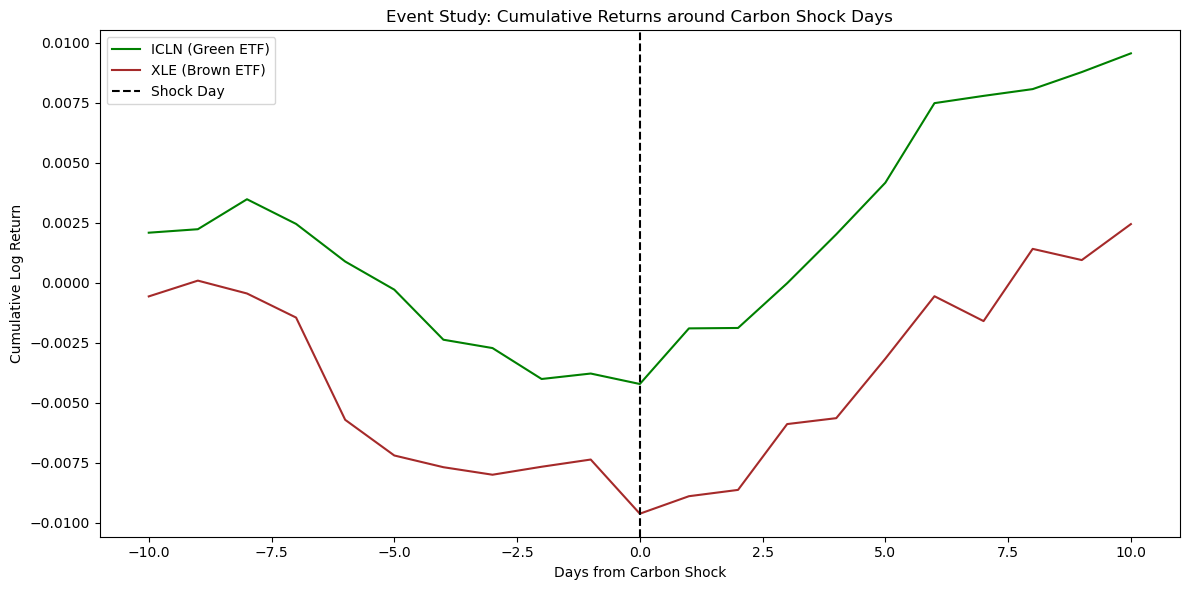


Average cumulative returns around shocks:
    days_from_shock  mean_cumret_icln  mean_cumret_xle
0               -10          0.002085        -0.000570
1                -9          0.002230         0.000088
2                -8          0.003479        -0.000449
3                -7          0.002451        -0.001452
4                -6          0.000884        -0.005714
5                -5         -0.000289        -0.007200
6                -4         -0.002375        -0.007689
7                -3         -0.002723        -0.008002
8                -2         -0.004012        -0.007670
9                -1         -0.003785        -0.007369
10                0         -0.004221        -0.009627
11                1         -0.001903        -0.008897
12                2         -0.001886        -0.008635
13                3         -0.000021        -0.005891
14                4          0.002017        -0.005645
15                5          0.004169        -0.003164
16                6   

In [4]:
df = pd.read_csv('/Users/marcomontenegro/Desktop/MSQE PROJECT/Project_Data/financial_data_returns_shocks_2018_2024.csv', index_col=0, parse_dates=True)

# Helper to detect correct ETF columns
def find_col(substring, columns):
    for col in columns:
        if substring.lower() in col.lower():
            return col
    return None

# Find ETF return columns
icln_col = find_col('ICLN', df.columns)
xle_col = find_col('XLE', df.columns)
icln_ret_col = f'{icln_col}_ret'
xle_ret_col = f'{xle_col}_ret'

# Safety check
if icln_ret_col not in df.columns or xle_ret_col not in df.columns:
    raise ValueError("Could not find ICLN or XLE return columns.")

# Find shock event indices (skip first/last 10 days to allow for window)
shock_indices = df.index[df['carbon_shock'] == 1]
shock_indices = [idx for idx in shock_indices if (df.index.get_loc(idx) > 10) and (df.index.get_loc(idx) < len(df)-10)]

window = 10  # Days before/after shock
event_matrix_icln = []
event_matrix_xle = []

for event_date in shock_indices:
    loc = df.index.get_loc(event_date)
    window_slice = slice(loc-window, loc+window+1)
    event_matrix_icln.append(df.iloc[window_slice][icln_ret_col].values)
    event_matrix_xle.append(df.iloc[window_slice][xle_ret_col].values)

event_matrix_icln = np.array(event_matrix_icln)
event_matrix_xle = np.array(event_matrix_xle)
event_time = np.arange(-window, window+1)

# Calculate average (mean) cumulative returns over event windows
mean_icln = np.nanmean(np.cumsum(event_matrix_icln, axis=1), axis=0)
mean_xle = np.nanmean(np.cumsum(event_matrix_xle, axis=1), axis=0)

# Plot event study result
plt.figure(figsize=(12,6))
plt.plot(event_time, mean_icln, label='ICLN (Green ETF)', color='green')
plt.plot(event_time, mean_xle, label='XLE (Brown ETF)', color='brown')
plt.axvline(0, color='black', linestyle='--', label='Shock Day')
plt.title('Event Study: Cumulative Returns around Carbon Shock Days')
plt.xlabel('Days from Carbon Shock')
plt.ylabel('Cumulative Log Return')
plt.legend()
plt.tight_layout()
plt.savefig('/Users/marcomontenegro/Desktop/MSQE PROJECT/Project_Data/event_study_cumulative_returns.png', dpi=300)
plt.show()

# Show as table as well
result_table = pd.DataFrame({
    'days_from_shock': event_time,
    'mean_cumret_icln': mean_icln,
    'mean_cumret_xle': mean_xle
})
print("\nAverage cumulative returns around shocks:")
print(result_table.head(2*window+1))

# Save table for reporting
result_table.to_csv('/Users/marcomontenegro/Desktop/MSQE PROJECT/Project_Data/event_study_cumulative_returns.csv', index=False)
print("\nSaved event study table as: event_study_cumulative_returns.csv")

# ------------------------------------------------------------
# END OF CHUNK 5
# ------------------------------------------------------------
